## 第十週：主題模型

組別：第七組

資料集：聯合新聞網

資料日期：2024/04/15 ~2024/05/05

資料筆數：9495筆

新聞類別：全球、社會、股市、產經

大綱：
1. 套件說明
2. 資料前處理 
3. lexicon-based 的主題模型
4. LDA 主題模型 
5. 視覺化主題模型 
6. GuidedLDA
7. 主題模型的應用

## 1. 套件說明

+ gensim: 主題模型函式庫
+ pyLDAvis: 互動式LDA視覺化套件

In [2]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint   
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim

In [3]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

## 2. 資料前處理

In [5]:
udn = pd.read_csv("raw_data/sna2024s_UDN.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,烏軍總司令：俄目標5月9日前奪東部前線西夫雅爾鎮,2024-04-15 07:53:00,全球,NaN,https://udn.com/news/story/122663/7899043,烏克蘭武裝部隊總司令瑟爾斯基今天表示，俄羅斯目標於5月9日前占領東部前線城鎮西夫雅爾，為目前...,UDN
1,2,以色列遇襲凸顯空防重要 烏克蘭籲美速援助抗俄,2024-04-15 11:08:00,全球,NaN,https://udn.com/news/story/122663/7899430,烏克蘭總統澤倫斯基（Volodymyr Zelenskyy）今天譴責伊朗對以色列發動無人機和...,UDN
2,3,烏克蘭核電廠瀕臨事故風險 幕後黑手是誰？ 國際原子能總署這樣說,2024-04-16 16:17:00,全球,NaN,https://udn.com/news/story/122663/7902447,聯合國國際原子能總署（IAEA）署長葛羅西今天警告，烏克蘭的札波羅熱（Zaporizhzhi...,UDN


In [6]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,烏克蘭武裝部隊總司令瑟爾斯基今天表示俄羅斯目標於月日前占領東部前線城鎮西夫雅爾為目前攻勢集中...,https://udn.com/news/story/122663/7899043,全球,2024-04-15 07:53:00
1,烏克蘭總統澤倫斯基今天譴責伊朗對以色列發動無人機和飛彈攻擊並表示烏克蘭需要盟友協助抵禦空中威...,https://udn.com/news/story/122663/7899430,全球,2024-04-15 11:08:00
2,聯合國國際原子能總署署長葛羅西今天警告烏克蘭的札波羅熱核電廠最近遭到攻擊瀕臨事故風險法新社報...,https://udn.com/news/story/122663/7902447,全球,2024-04-16 16:17:00


利用jieba斷詞，多了「words」欄位來儲存斷詞結果，型態：list

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_3rd/week10/dict/dict.txt ...
2024-05-07 10:25:42,346 : DEBUG : Building prefix dict from /Users/wuanjie/Desktop/NLP/SocialAnalysis_3rd/week10/dict/dict.txt ...
Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u60c6c0577929ff4c4e5735bf8440f309.cache
2024-05-07 10:25:42,355 : DEBUG : Loading model from cache /var/folders/bd/hbhq4wsn28d9hg6673m4blg00000gn/T/jieba.u60c6c0577929ff4c4e5735bf8440f309.cache


Loading model cost 1.774 seconds.
2024-05-07 10:25:44,127 : DEBUG : Loading model cost 1.774 seconds.
Prefix dict has been built successfully.
2024-05-07 10:25:44,129 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,烏克蘭武裝部隊總司令瑟爾斯基今天表示俄羅斯目標於月日前占領東部前線城鎮西夫雅爾為目前攻勢集中...,https://udn.com/news/story/122663/7899043,全球,2024-04-15 07:53:00,"[烏克蘭, 武裝, 部隊, 總司令, 瑟爾, 斯基, 今天, 表示, 俄羅斯, 目標, 日前..."
1,烏克蘭總統澤倫斯基今天譴責伊朗對以色列發動無人機和飛彈攻擊並表示烏克蘭需要盟友協助抵禦空中威...,https://udn.com/news/story/122663/7899430,全球,2024-04-15 11:08:00,"[烏克蘭, 總統, 澤倫, 斯基, 今天, 譴責, 伊朗, 以色列, 發動, 無人機, 飛彈..."
2,聯合國國際原子能總署署長葛羅西今天警告烏克蘭的札波羅熱核電廠最近遭到攻擊瀕臨事故風險法新社報...,https://udn.com/news/story/122663/7902447,全球,2024-04-16 16:17:00,"[聯合國, 國際, 原子能, 總署, 署長, 羅西, 今天, 警告, 烏克蘭, 波羅, 核電..."
3,以色列於伊朗日報復攻擊時宣稱在美國和區域內有軍事能力的夥伴幫助下擊落的來襲無人機與飛彈看在獨...,https://udn.com/news/story/122663/7902492,全球,2024-04-16 17:39:00,"[以色列, 伊朗, 報復, 攻擊, 宣稱, 美國, 區域, 內有, 軍事, 能力, 夥伴, ..."
4,美英等國日出動戰機協助以色列攔截伊朗發射的飛彈和無人機但英國外交大臣卡麥隆日表示若部署西方國...,https://udn.com/news/story/122663/7902838,全球,2024-04-16 17:41:00,"[美英, 國日, 出動, 戰機, 協助, 以色列, 攔截, 伊朗, 發射, 飛彈, 無人機,..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [8]:
udn['artCatagory'].unique()

array(['全球', '社會', '產經', '股市'], dtype=object)


在「社會」中出現頻率最高的前100個單詞

In [9]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '社會',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['警方', '男子', '表示', '發現', '今天', '法官', '調查', '發生', '萬元', '指出', '人員', '記者',
       '法院', '認為', '民眾', '檢方', '現場', '北市', '駕駛', '翻攝', '死刑', '員警', '去年', '起訴',
       '機車', '提供', '地檢署', '公司', '女子', '造成', '相關', '毒品', '偵辦', '檢察官', '罪嫌',
       '送醫', '下午', '上午', '醫院', '犯罪', '地院', '到場', '昨天', '被害人', '台中', '詐騙', '台灣',
       '交通', '消防局', '行為', '案件', '原因', '一名', '目前', '判決', '前往', '協助', '處理', '生命',
       '執行', '違反', '集團', '高雄', '工作', '上訴', '獲報', '審理', '派出所', '無法', '台北', '安全',
       '車輛', '投資', '釐清', '立即', '事故', '要求', '報案', '規定', '涉嫌', '分局', '家屬', '陳男',
       '專線', '受傷', '台南', '全案', '警分局', '凌晨', '社會', '網路', '律師', '陳姓', '時分', '時許',
       '司法', '進行', '資料', '透過', '行經'],
      dtype='object', name='words')

在「股市」中出現頻率最高的前100個單詞

In [10]:
stock_cnt = udn.loc[udn['artCatagory'] == '股市',:]['words'].explode().value_counts().head(200)
pprint(" ".join(stock_cnt.index))

('市場 今年 億元 台股 營收 成長 投資 公司 指數 第季 表示 持續 美國 預期 表現 去年 台灣 產品 產業 需求 台積電 投資人 股息 法人 全球 '
 '相關 上漲 目前 營運 股價 獲利 基金 指出 客戶 半導體 主要 下跌 外資 企業 影響 年增 股利 純益 科技 未來 增加 展望 降息 動能 每股 '
 '超過 布局 股市 配息 機會 帶動 發展 經濟 預估 股票 財報 債券 首季 現金 包括 漲幅 投信 可望 昨日 看好 交易 預計 資金 風險 高息 '
 '受惠 應用 同期 提供 近期 國際 公布 維持 證券 提升 趨勢 美股 伺服器 期貨 毛利率 永續 電子 技術 殖利率 價格 新高 資本 認為 建議 '
 '服務 今天 買超 方面 合併 有望 金額 聯準會 大盤 業務 長期 透過 成為 美元 觀察 智慧 中國 訂單 賣超 震盪 上市 調整 優於 下半年 資產 '
 '業績 規模 出貨 出現 族群 公告 大陸 顯示 進行 相對 今日 政策 股東 三大 盤中 強勁 晶片 產能 跌幅 類股 通膨 時間 數據 新台幣 收益 '
 '積極 發行 穩定 個股 市值 歷史 金融 統計 大漲 臺灣 行情 平均 日本 法說 董事會 管理 大跌 擴大 進入 策略 萬元 大幅 庫存 集團 中東 '
 '合作 復甦 目標 配發 資訊 終場 利率 供應鏈 國內 先進 推出 走勢 設備 後市 減少 董事長 年減 分析 關注 銷售 加碼 經理人 進一步 系統 '
 '成分股 後續')


在「全球」中出現頻率最高的前100個單詞

In [11]:
global_cnt = udn.loc[udn['artCatagory'] == '全球',:]['words'].explode().value_counts().head(200)
pprint(" ".join(global_cnt.index))

('美國 以色列 表示 中國 報導 伊朗 日本 公司 指出 政府 國家 今年 市場 美元 川普 今天 經濟 台灣 去年 大學 烏克蘭 攻擊 認為 總統 億美 '
 '全球 拜登 官員 預期 包括 戰爭 安全 支持 巴勒斯坦 學生 進行 衝突 目前 俄羅斯 影響 國際 時間 提供 大陸 發生 英國 投資 地區 行動 '
 '瑪斯 媒體 活動 人士 問題 抗議 歐洲 指數 持續 顯示 飛彈 德國 數據 組織 報告 日圓 政策 成長 關係 合作 加薩 調查 要求 降息 通膨 '
 '國會 政治 計畫 宣布 企業 造成 工作 校園 導致 目標 軍事 使用 世界 法案 希望 增加 超過 總理 歐盟 相關 聲明 示威 系統 正在 主要 '
 '公布 成為 一名 中東 無人機 援助 上漲 重要 出現 研究 印度 仇恨 更多 透過 未來 人員 故事 戰火 聯邦 接受 警方 舉行 北京 發布 當局 '
 '會議 採取 需求 利率 現在 銀行 百年 面臨 民眾 晶片 發動 決定 情況 無法 行為 布林肯 風險 消息 報復 過去 歷史 協議 新聞 事件 提出 '
 '營收 投資人 需要 科技 維持 空襲 期間 代表 進一步 價格 法國 主義 下跌 發現 特斯拉 訪問 技術 發展 能源 獲得 南韓 選舉 襲擊 強調 '
 '不斷 機構 委員會 回應 產品 分析師 呼籲 現場 一直 法新社 聯準會 繼續 這項 引發 聯合國 進入 預計 內容 參與 部門 嚴重 透露 紐約 討論 '
 '設施 中心 澳洲')


In [12]:
custom_topic_word = {
    "社會": [
        "警方",
        "發生",
        "調查",
        "記者",
        "檢方",
        "現場",
        "相關",
        "偵辦",
        "民眾",
        "台灣",
        "台北",
        "釐清",
        "工作",
        "投資",
        "接獲",
        "台中市",
        "高雄",
        "今年",
        "台南市",
        "持續",
        "違規",
        "晚間",
        "午時",
        "狀況",
        "學生",
        "國家",
    ],
    "股市": [
        "市場",
        "成長",
        "投資",
        "指數",
        "台股",
        "每股",
        "營運",
        "股利",
        "獲利",
        "現金",
        "年增",
        "股價",
        "投資人",
        "法人",
        "銀行",
        "上漲",
        "升息",
        "外資",
        "殖利率",
        "股息",
        "配發",
        "股票",
        "基金",
        "上市",
        "配息",
        "金融",
        "聯準會",
        "買超",
        "債券",
        "動能",
        "下跌",
        "漲幅",
    ],
    "產經": [
        "產業",
        "產品",
        "需求",
        "客戶",
        "董事會",
        "公司",
        "營收",
        "經濟",
        "庫存",
        "企業",
        "國際",
        "台積電",
        "業務",
        "盈餘",
        "風險",
        "服務",
        "資本",
        "機會",
        "集團",
        "電子",
        "半導體",
        "能源",
        "布局",
        "科技",
        "電動車",
        "智慧",
        "鴻海",
        "品牌",
        "網路",
    ],
    "全球": [
        "美國",
        "以色列",
        "巴勒斯坦",
        "中國",
        "俄羅斯",
        "烏克蘭",
        "南韓",
        "歐盟",
        "日本",
    ],
}

In [14]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

將dictionary轉換成一個單詞的列表->vocabularies，包含了上面定義的所有主題詞

In [15]:
vocabularies

array(['上市', '上漲', '下跌', '中國', '今年', '以色列', '企業', '俄羅斯', '偵辦', '債券', '公司',
       '動能', '升息', '午時', '半導體', '南韓', '台中市', '台北', '台南市', '台灣', '台積電',
       '台股', '品牌', '國家', '國際', '基金', '外資', '學生', '客戶', '工作', '巴勒斯坦', '市場',
       '布局', '年增', '庫存', '成長', '投資', '投資人', '持續', '指數', '接獲', '日本', '晚間',
       '智慧', '服務', '業務', '機會', '檢方', '歐盟', '殖利率', '每股', '民眾', '法人', '漲幅',
       '烏克蘭', '營收', '營運', '狀況', '獲利', '現場', '現金', '產品', '產業', '發生', '盈餘',
       '相關', '科技', '經濟', '網路', '美國', '聯準會', '股價', '股利', '股息', '股票', '能源',
       '董事會', '記者', '調查', '警方', '買超', '資本', '違規', '配息', '配發', '釐清', '金融',
       '銀行', '集團', '電動車', '電子', '需求', '風險', '高雄', '鴻海'], dtype='<U4')

利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM

In [17]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [18]:
udn_matrix.shape

(9495, 95)

透過上面定義的詞彙，去計算在不同文章中不同主題相關的詞彙數出現次數

In [19]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
    
df_count

,topic_社會,topic_股市,topic_產經,topic_全球
0,0,0,0,6
1,1,1,0,14
2,2,0,5,5
3,3,0,0,27
4,4,0,1,13
...,...,...,...,...
9490,4,2,22,1
9491,4,13,17,0
9492,0,9,5,0
9493,4,11,9,2


換算成比率後，可以透過觀察主題的比率高低判斷每篇文章的主題

1. 第0篇文章，「全球」相關的詞彙有100%，其他比率為0% -> 「全球」
2. 第1篇文章，「全球」相關的詞彙有87.5%，「社會」「產經」皆佔6.25% -> 「全球」
3. 第2篇文章，「產經」「全球」各佔約41.6% -> 主題可能是綜合「全球」「產經」
2. 第3篇文章，「社會」相關的詞彙有10%，「全球」有90% -> 「全球」 

In [20]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_社會,topic_股市,topic_產經,topic_全球
0,0.000000,0.0000,0.000000,1.000000
1,0.062500,0.0625,0.000000,0.875000
2,0.166667,0.0000,0.416667,0.416667
3,0.100000,0.0000,0.000000,0.900000
4,0.222222,0.0000,0.055556,0.722222


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文檔集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

簡單的範例說明 `gensim` bag of word 的方式

**4.1 正式處理新聞**

將words轉換成list

In [21]:
docs = udn['words'].to_list()
docs[0]

['烏克蘭',
 '武裝',
 '部隊',
 '總司令',
 '瑟爾',
 '斯基',
 '今天',
 '表示',
 '俄羅斯',
 '目標',
 '日前',
 '占領',
 '東部',
 '前線',
 '城鎮',
 '西夫',
 '雅爾為',
 '目前',
 '攻勢',
 '集中',
 '東部',
 '俄軍',
 '發起',
 '重要',
 '戰役',
 '爭奪',
 '掌控',
 '高地',
 '作好',
 '準備',
 '路透社',
 '報導',
 '俄羅斯',
 '勝利日',
 '紀念',
 '蘇聯',
 '第二次世界大戰',
 '戰勝',
 '納粹',
 '德國',
 '日子',
 '總統',
 '蒲亭',
 '照例',
 '主持',
 '莫斯科',
 '紅場',
 '閱兵',
 '俄羅斯',
 '迅速',
 '奪下',
 '位在',
 '巴赫',
 '西邊',
 '戰前',
 '人口',
 '萬人',
 '西夫',
 '雅爾鎮',
 '將會',
 '凸顯',
 '基輔',
 '努力',
 '因應',
 '西方',
 '軍援',
 '遲緩',
 '之際',
 '莫斯科',
 '戰場',
 '勢頭',
 '正盛',
 '瑟爾',
 '斯基',
 '週末',
 '警告',
 '東部',
 '情勢',
 '已然',
 '惡化',
 '表示',
 '俄羅斯',
 '正將',
 '精力',
 '集中',
 '巴赫',
 '以西',
 '試圖',
 '拿下',
 '西夫',
 '雅爾鎮',
 '克拉',
 '莫托斯克',
 '挺進',
 '加密',
 '通訊',
 '軟體',
 '表示',
 '烏軍',
 '東部',
 '頓內茨',
 '克州',
 '暫時',
 '頂住',
 '俄軍',
 '攻勢',
 '補強',
 '彈藥',
 '無人機',
 '電子戰',
 '裝置',
 '瑟爾',
 '斯基',
 '考量',
 '俄羅斯',
 '軍事',
 '領導層',
 '已為',
 '軍隊',
 '設定',
 '日前',
 '奪下',
 '西夫雅爾',
 '任務',
 '威脅',
 '仍須',
 '重視']

In [22]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-07 10:32:33,246 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-07 10:32:38,093 : INFO : built Dictionary<93274 unique tokens: ['主持', '之際', '人口', '今天', '仍須']...> from 9495 documents (total 2344057 corpus positions)
2024-05-07 10:32:38,102 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<93274 unique tokens: ['主持', '之際', '人口', '今天', '仍須']...> from 9495 documents (total 2344057 corpus positions)", 'datetime': '2024-05-07T10:32:38.102793', 'gensim': '4.3.2', 'python': '3.11.4 (v3.11.4:d2340ef257, Jun  6 2023, 19:15:51) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.5-x86_64-i386-64bit', 'event': 'created'}
2024-05-07 10:32:38,271 : INFO : discarding 68094 tokens: [('正盛', 3), ('照例', 1), ('紅場', 1), ('莫托斯克', 3), ('西夫', 3), ('西夫雅爾', 2), ('西邊', 4), ('閱兵', 2), ('雅爾為', 2), ('雅爾鎮', 3)]...
2024-05-07 10:32:38,273 : INFO : keeping 25180 tokens which were in no less than 5 and no more than 9400 (=99.0%) documents
2024-05-07 10:32:38,495 : INFO

Dictionary<25180 unique tokens: ['主持', '之際', '人口', '今天', '仍須']...>


In [23]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

主持: 0
之際: 1
人口: 2
今天: 3
仍須: 4
以西: 5
任務: 6
位在: 7
作好: 8
俄羅斯: 9
俄軍: 10
克州: 11


將斷詞結果建構語料庫(corpus)之後，利用語料庫把每篇文章數字化。<br>
每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。<br>


`iloc[600]` 是用來選擇索引第600篇文章

In [24]:
pprint(" ".join(udn['words'].iloc[600]))


('美國 國務卿 布林肯 本周 訪問 中國 大陸 商討 台海 烏克蘭 北韓 中東 情勢 中國 大陸 公平 貿易 議題 美國 聯邦 眾議院 加強 中國 大陸 '
 '施壓 規模 億美 安全 援助 烏克蘭 以色列 台灣 法案 要求 一年 脫離 字節 跳動 將在 美國 遭禁 美國 國務院 表示 布林肯 將於日 造訪 北京 '
 '上海 美方 官員 表示 布林肯 警告 北京 當局 中國 大陸 停止 出口 軍武 相關 技術 俄國 美國 考慮 中國 大陸 金融 機構 採取 懲罰 行動 '
 '成為 布林肯 迄今 中方 官員 明確 警告 美國 一直 準備 台灣 準總統 賴清德 就職 典禮 布林肯 敦促 中方 克制 維持 台海 和平 穩定 也將 '
 '提到 中東 危機 中國 大陸 南海 挑釁 行為 北韓 魯莽 言詞 行動 並將 明確 坦率 提出 美國 人權 公平 經濟 貿易 行為 中國 大陸 工業 '
 '產能 過剩 問題 關切 眾議院 接連 規模 億美 國安 法案 批准 烏克蘭 軍援 金援 億美 軍援 以色列 億美 印太 地區 軍援 億美 包括 對台 '
 '軍援 億美 印太 安全 補充 法案 包括 億美 提供 台灣 主要 盟友 外國 軍事 融資 億美 用於 補充 提供給 台灣 防禦性 軍事 物資 眾院 世紀 '
 '透過 實力 達成 和平 法案 內容 凍結 俄羅斯 主權 資產 制裁 伊朗 要求 字節 跳動 須在 一年 出售 將在 美國 面臨 全國 禁令')


In [25]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(9, 1),
 (32, 1),
 (49, 1),
 (50, 3),
 (69, 2),
 (75, 2),
 (77, 2),
 (78, 4),
 (92, 1),
 (97, 2)]

In [26]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [27]:
type(corpus)

list

訓練 topic model

+ 參數說明：
    + corpus = 文檔語料庫
    + id2word = 詞彙字典
    + num_topics = 生成幾個主題數
    + random_state = 固定亂數值，每次的模型結果會一樣
    + iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
    + passes(epoch) = 整個 corpus 訓練模型的次數
    + alpha = 文章主題分佈
    + eta = 主題字分佈


In [28]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # ★生成幾個主題數
    random_state=2024, # 亂數
)

2024-05-07 10:32:54,646 : INFO : using symmetric alpha at 0.1
2024-05-07 10:32:54,664 : INFO : using symmetric eta at 0.1
2024-05-07 10:32:54,726 : INFO : using serial LDA version on this node
2024-05-07 10:32:54,846 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 9495 documents, updating model once every 2000 documents, evaluating perplexity every 9495 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-07 10:32:54,847 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-07 10:32:54,855 : INFO : PROGRESS: pass 0, at document #2000/9495
2024-05-07 10:32:57,074 : INFO : merging changes from 2000 documents into a model of 9495 documents
2024-05-07 10:32:57,109 : INFO : topic #5 (0.100): 0.020*"美國" + 0.009*"以色列" + 0.009*"表示" + 0.008*"中國" + 0.005*"報導" + 0.005*"政府" + 0.004*"烏克蘭" + 0.003*"伊朗" + 0.003*"國家" + 0.003*"飛彈"
2024-05-07 10:

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

舉例來說：<br>
`'0.012*"億元" + 0.010*"今年" + 0.010*"市場" + 0.010*"營收" + 0.008*"第季" + 0.008*"成長" + 0.008*"台股" + 0.007*"公司" + 0.006*"產品" + 0.006*"持續"'`  

In [29]:
ldamodel.print_topics()

2024-05-07 10:33:23,708 : INFO : topic #0 (0.100): 0.012*"億元" + 0.010*"今年" + 0.010*"市場" + 0.010*"營收" + 0.008*"第季" + 0.008*"成長" + 0.008*"台股" + 0.007*"公司" + 0.006*"產品" + 0.006*"持續"
2024-05-07 10:33:23,711 : INFO : topic #1 (0.100): 0.008*"台灣" + 0.005*"高雄" + 0.004*"表示" + 0.004*"公司" + 0.004*"回饋" + 0.004*"提供" + 0.004*"活動" + 0.003*"品牌" + 0.003*"金管會" + 0.003*"推出"
2024-05-07 10:33:23,713 : INFO : topic #2 (0.100): 0.008*"表示" + 0.005*"公司" + 0.005*"集團" + 0.004*"系統" + 0.004*"提供" + 0.004*"申報" + 0.004*"今年" + 0.004*"投資" + 0.004*"員工" + 0.004*"所得"
2024-05-07 10:33:23,716 : INFO : topic #3 (0.100): 0.016*"伊朗" + 0.015*"以色列" + 0.014*"死刑" + 0.008*"無人機" + 0.006*"流感" + 0.006*"表示" + 0.006*"台灣" + 0.005*"攻擊" + 0.005*"憲法" + 0.005*"國際"
2024-05-07 10:33:23,717 : INFO : topic #4 (0.100): 0.007*"桃園" + 0.007*"表示" + 0.006*"大學" + 0.006*"學生" + 0.005*"警方" + 0.004*"醫院" + 0.004*"萬元" + 0.004*"發現" + 0.004*"法院" + 0.003*"認為"
2024-05-07 10:33:23,720 : INFO : topic #5 (0.100): 0.011*"美國" + 0.007*"表示" + 0.007*"川普" + 0.006*"台灣" +

[(0,
  '0.012*"億元" + 0.010*"今年" + 0.010*"市場" + 0.010*"營收" + 0.008*"第季" + 0.008*"成長" + 0.008*"台股" + 0.007*"公司" + 0.006*"產品" + 0.006*"持續"'),
 (1,
  '0.008*"台灣" + 0.005*"高雄" + 0.004*"表示" + 0.004*"公司" + 0.004*"回饋" + 0.004*"提供" + 0.004*"活動" + 0.003*"品牌" + 0.003*"金管會" + 0.003*"推出"'),
 (2,
  '0.008*"表示" + 0.005*"公司" + 0.005*"集團" + 0.004*"系統" + 0.004*"提供" + 0.004*"申報" + 0.004*"今年" + 0.004*"投資" + 0.004*"員工" + 0.004*"所得"'),
 (3,
  '0.016*"伊朗" + 0.015*"以色列" + 0.014*"死刑" + 0.008*"無人機" + 0.006*"流感" + 0.006*"表示" + 0.006*"台灣" + 0.005*"攻擊" + 0.005*"憲法" + 0.005*"國際"'),
 (4,
  '0.007*"桃園" + 0.007*"表示" + 0.006*"大學" + 0.006*"學生" + 0.005*"警方" + 0.004*"醫院" + 0.004*"萬元" + 0.004*"發現" + 0.004*"法院" + 0.003*"認為"'),
 (5,
  '0.011*"美國" + 0.007*"表示" + 0.007*"川普" + 0.006*"台灣" + 0.005*"總統" + 0.005*"政府" + 0.004*"候選人" + 0.004*"拜登" + 0.004*"董事" + 0.004*"支持"'),
 (6,
  '0.017*"中鋼" + 0.007*"表示" + 0.007*"警方" + 0.006*"桃園" + 0.005*"今天" + 0.005*"駕駛" + 0.004*"紀念品" + 0.004*"男子" + 0.004*"法官" + 0.004*"汽車"'),
 (7,
  '0.009*"市場" + 0

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題 0：包括「移工」、「以色列」、「流感」、「病毒」、「致死」等詞彙 → 國際疫情、公衛議題
+ 主題 1：包括「警方」、「男子」、「萬元」、「法官」、「機車」等詞彙 → 交通事故、犯罪、法律案件
+ 主題 2：包括「投資」、「基金」、「市場」、「美國」、「全球」等詞彙 → 全球經濟、投資市場和財經新聞
+ 主題 3：包括「今年」、「億元」、「投資」、「公司」等詞彙 → 企業投資、經濟發展和市場動態
+ 主題 4：包括「投資」、「金管會」、「公司」等詞彙 → 金融監管、企業財務和投資策略相關
+ 主題 5：包括「市場」、「公司」、「技術」、「產品」等詞彙 → 科技創新、企業市場表現和產業發展
+ 主題 6：包括「億元」、「台灣」、「集團」、「企業」等詞彙 → 台灣本土的企業發展、經濟活動和市場情況
+ 主題 7：包括「億元」、「市場」、「台股」、「成長」等詞彙 → 台灣股市、市場趨勢和經濟成長
+ 主題 8：包括「台灣」、「美國」、「董事」、「合作」等詞彙 → 台美之間的商業互動或外交活動
+ 主題 9：包括「廣達」、「伺服器」、「輝達」、「億美元」、「營收」等詞彙 → 科技公司和產業經濟

也可以使用 `get_document_topics()` 回去看每篇文章的主題分佈 (`theta`)

In [30]:
ldamodel.get_document_topics(corpus[0])

[(3, 0.61436516), (5, 0.31667826), (6, 0.030063527), (8, 0.033506185)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information (PMI)** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [31]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-07 10:33:56,882 : INFO : -9.117 per-word bound, 555.1 perplexity estimate based on a held-out corpus of 9495 documents with 2200744 words


-9.116687634998215

In [32]:
np.exp2(-perplexity)

555.1322259051238

In [33]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-07 10:34:12,567 : INFO : using ParallelWordOccurrenceAccumulator<processes=3, batch_size=64> to estimate probabilities from sliding windows
2024-05-07 10:34:21,192 : INFO : 1 batches submitted to accumulate stats from 64 documents (13391 virtual)
2024-05-07 10:34:21,205 : INFO : 2 batches submitted to accumulate stats from 128 documents (29073 virtual)
2024-05-07 10:34:21,231 : INFO : 3 batches submitted to accumulate stats from 192 documents (51993 virtual)
2024-05-07 10:34:21,255 : INFO : 4 batches submitted to accumulate stats from 256 documents (72786 virtual)
2024-05-07 10:34:21,280 : INFO : 5 batches submitted to accumulate stats from 320 documents (96203 virtual)
2024-05-07 10:34:21,294 : INFO : 6 batches submitted to accumulate stats from 384 documents (111811 virtual)
2024-05-07 10:34:21,864 : INFO : 7 batches submitted to accumulate stats from 448 documents (125404 virtual)
2024-05-07 10:34:22,128 : INFO : 8 batches submitted to accumulate stats from 512 documents (13

這個主題的 PMI score:  -0.006061207856015118


In [34]:
NPMI_model_lda.get_coherence_per_topic()

[0.06147747813646928,
 -0.03711475641046081,
 -0.011428773274572559,
 -0.0445393809650577,
 -0.0027669753318955584,
 -0.028514649862817168,
 -0.06388955345476359,
 0.01710508661818171,
 0.006689412524153078,
 0.042370033460612126]

`NPMI` 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡我們選擇主題數 2~10 來做分析。

In [35]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()

for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

### 花費時間: 99.35791897773743 sec

2024-05-07 10:35:28,712 : INFO : using symmetric alpha at 0.5
2024-05-07 10:35:28,728 : INFO : using symmetric eta at 0.5
2024-05-07 10:35:28,740 : INFO : using serial LDA version on this node
2024-05-07 10:35:28,755 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 9495 documents, updating every 6000 documents, evaluating every ~9495 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-07 10:35:28,758 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-07 10:35:28,761 : INFO : training LDA model using 3 processes
2024-05-07 10:35:36,782 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/9495, outstanding queue size 1
2024-05-07 10:35:36,945 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/9495, outstanding queue size 2
2024-05-07 10:35:36,969 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents 

花費時間: 1203.4769270420074 sec


訓練要花一點時間，同學可以研究看看平行運算的 `gensim.models.ldamulticore.LdaMulticore()` class 或是其他方法

In [36]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,5309.072830,0.001526
1,3,4640.359756,0.028120
2,4,4372.003103,0.028649
3,5,4228.019599,0.022374
4,6,4258.108884,0.018329
5,7,4134.232496,0.023427
6,8,4033.847040,0.025637
7,9,3984.989682,0.024319


<AxesSubplot:xlabel='topic_num'>

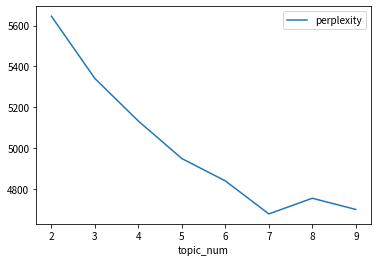

In [54]:
result.plot.line(x='topic_num', y='perplexity')

可以看出主題數為7~9之間，perplexity都算低，7是最低的

<AxesSubplot:xlabel='topic_num'>

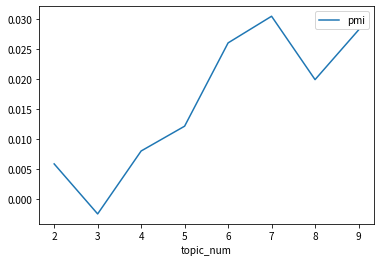

In [55]:
result.plot.line(x='topic_num', y='pmi')

主題數7的 pmi最高

透過兩個指標找到最佳的主題數（topics_num = 7）

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 圓圈數量代表主題數量，有幾個主題就會有幾個圓圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 7 來做 LDAvis 的結果範例

In [37]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-07 10:57:59,084 : INFO : using symmetric alpha at 0.14285714285714285
2024-05-07 10:57:59,105 : INFO : using symmetric eta at 0.14285714285714285
2024-05-07 10:57:59,120 : INFO : using serial LDA version on this node


2024-05-07 10:57:59,173 : INFO : running online (multi-pass) LDA training, 7 topics, 5 passes over the supplied corpus of 9495 documents, updating model once every 2000 documents, evaluating perplexity every 9495 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-07 10:57:59,184 : INFO : PROGRESS: pass 0, at document #2000/9495
2024-05-07 10:58:01,506 : INFO : merging changes from 2000 documents into a model of 9495 documents
2024-05-07 10:58:01,528 : INFO : topic #1 (0.143): 0.008*"表示" + 0.008*"美國" + 0.007*"以色列" + 0.006*"中國" + 0.006*"伊朗" + 0.005*"報導" + 0.004*"公司" + 0.004*"台灣" + 0.004*"國家" + 0.004*"烏克蘭"
2024-05-07 10:58:01,559 : INFO : topic #0 (0.143): 0.011*"以色列" + 0.010*"美國" + 0.010*"表示" + 0.008*"伊朗" + 0.008*"中國" + 0.007*"報導" + 0.004*"億美" + 0.004*"日本" + 0.004*"國家" + 0.003*"今天"
2024-05-07 10:58:01,602 : INFO : topic #5 (0.143): 0.019*"以色列" + 0.012*"美國" + 0.011*"伊朗" + 0.007*"表示" + 0.007*"報導" + 0.007*"中國" + 0.005*"日本" + 0.004*"瑪斯" + 0.004*"攻擊" + 0.004*"烏克蘭"
2024-

In [38]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.216278 -0.003064       1        1  23.710844
6     -0.053533  0.124604       2        1  17.134379
4     -0.189894 -0.014345       3        1  14.925344
0      0.289500  0.100022       4        1  13.327368
5      0.112188 -0.248108       5        1  10.571452
3      0.025326 -0.112041       6        1  10.520701
1      0.032691  0.152934       7        1   9.809913, topic_info=     Term         Freq        Total Category  logprob  loglift
97    以色列  4934.000000  4934.000000  Default  30.0000  30.0000
155    美國  9275.000000  9275.000000  Default  29.0000  29.0000
98     伊朗  3334.000000  3334.000000  Default  28.0000  28.0000
2153   市場  9216.000000  9216.000000  Default  27.0000  27.0000
1280   產品  3623.000000  3623.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
502    集團   468.738153  3322.205644   Topic7  -6.1325   0.3634
555    能源   432.236753  1825.688028   Topic7  -6.2136   0.8810
603    政府   466.143972  4330.493799   Topic7  -6.1380   0.0928
844    今年   499.832081  9832.586394   Topic7  -6.0683  -0.6574
313    指出   463.279209  6073.513863   Topic7  -6.1442  -0.2516

[590 rows x 6 columns], token_table=       Topic      Freq Term
term                       
755        1  0.008731   一名
755        2  0.047146   一名
755        3  0.001746   一名
755        4  0.643462   一名
755        5  0.226128   一名
...      ...       ...  ...
7447       6  0.978175  黃循財
18404      4  0.995689   黃男
20227      1  0.090979   龍潭
20227      3  0.011867   龍潭
20227      7  0.893963   龍潭

[1712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 5, 1, 6, 4, 2])

可以看到(2,7)、(1,3)彼此離很相近，代表說這幾個主題是越相關的。<br>
試試看跑4個主題

In [39]:
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(model_5, corpus, dictionary)
p

2024-05-07 11:00:37,094 : INFO : using symmetric alpha at 0.25
2024-05-07 11:00:37,123 : INFO : using symmetric eta at 0.25
2024-05-07 11:00:37,141 : INFO : using serial LDA version on this node
2024-05-07 11:00:37,177 : INFO : running online (multi-pass) LDA training, 4 topics, 5 passes over the supplied corpus of 9495 documents, updating model once every 2000 documents, evaluating perplexity every 9495 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-07 11:00:37,185 : INFO : PROGRESS: pass 0, at document #2000/9495


2024-05-07 11:00:40,020 : INFO : merging changes from 2000 documents into a model of 9495 documents
2024-05-07 11:00:40,043 : INFO : topic #0 (0.250): 0.013*"以色列" + 0.012*"美國" + 0.009*"表示" + 0.009*"中國" + 0.008*"伊朗" + 0.007*"報導" + 0.004*"日本" + 0.004*"烏克蘭" + 0.004*"國家" + 0.003*"億美"
2024-05-07 11:00:40,047 : INFO : topic #1 (0.250): 0.009*"美國" + 0.009*"以色列" + 0.008*"表示" + 0.008*"中國" + 0.006*"報導" + 0.006*"伊朗" + 0.004*"烏克蘭" + 0.004*"公司" + 0.003*"指出" + 0.003*"國家"
2024-05-07 11:00:40,052 : INFO : topic #2 (0.250): 0.010*"表示" + 0.009*"美國" + 0.007*"以色列" + 0.007*"伊朗" + 0.005*"市場" + 0.005*"美元" + 0.005*"預期" + 0.005*"日本" + 0.004*"今年" + 0.004*"公司"
2024-05-07 11:00:40,058 : INFO : topic #3 (0.250): 0.015*"美國" + 0.011*"以色列" + 0.010*"中國" + 0.007*"表示" + 0.006*"伊朗" + 0.006*"報導" + 0.005*"政府" + 0.004*"日本" + 0.004*"國家" + 0.004*"市場"
2024-05-07 11:00:40,062 : INFO : topic diff=3.288848, rho=1.000000
2024-05-07 11:00:40,075 : INFO : PROGRESS: pass 0, at document #4000/9495
2024-05-07 11:00:42,181 : INFO : merg

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.216826  0.067345       1        1  32.774825
1      0.082156  0.043525       2        1  32.445672
3     -0.038442 -0.211907       3        1  17.735642
0     -0.260540  0.101037       4        1  17.043860, topic_info=      Term         Freq        Total Category  logprob  loglift
155     美國  9243.000000  9243.000000  Default  30.0000  30.0000
97     以色列  4403.000000  4403.000000  Default  29.0000  29.0000
2037    億元  6383.000000  6383.000000  Default  28.0000  28.0000
839     中國  4487.000000  4487.000000  Default  27.0000  27.0000
98      伊朗  2954.000000  2954.000000  Default  26.0000  26.0000
...    ...          ...          ...      ...      ...      ...
895     認為   995.458833  3772.313413   Topic4  -5.9317   0.4371
313     指出  1071.384264  6082.473804   Topic4  -5.8582   0.0329
17098   北市   779.026291  2268.059504   Topic4  -6.1769   0.7007
167     造成   737.655499  2121.541418   Topic4  -6.2314   0.7130
696     去年   781.411788  6085.196374   Topic4  -6.1738  -0.2831

[338 rows x 6 columns], token_table=       Topic      Freq Term
term                       
755        1  0.033739   一名
755        2  0.020061   一名
755        3  0.264442   一名
755        4  0.682078   一名
1520       1  0.996531   上漲
...      ...       ...  ...
9120       3  0.001859   體驗
9120       4  0.001859   體驗
21694      1  0.997293   高息
24350      2  0.988359   高爐
24350      3  0.007214   高爐

[785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

替換成4個主題數後，可以發現文章有更明顯的分群，可以更好的觀察文本中的資訊！<br>
透過人工判定，查看不同主題裡面詞彙代表的主題類別！

* 主題1：主要與金融市場相關的主題，像是股市投資、財經分析和金融交易
* 主題2：主要與經濟產業發展、國際貿易等主題相關
* 主題3：主要是與國際關係和地緣政治相關，常出現在討論國際政治的脈絡中，特別是關於安全、外交政策和國際合作
* 主題4：刑事司法與公共安全，可以看到與法律相關的職位等詞彙

我們可以透過兩個指標去做為選擇主題數的參考，但不一定是最佳解，還是可以透過人工去判斷

In [98]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

In [40]:
import guidedlda

In [41]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('主持', '之際', '人口', '今天', '仍須', '以西', '任務', '位在', '作好', '俄羅斯')

In [42]:
word2id = dictionary.token2id

定義了以下5個主題種子字，藉由給定每個主題一些關鍵字，去影響主題模型生成的結果！

In [43]:
seed_topic_list = [
    ["烏克蘭", "俄羅斯", "無人機", "占領", "爭奪"],
    ["以色列", "巴勒斯坦", "飛彈", "衝突", "美國"],
    ["總統", "台海" , "賴清德" , "和平" , "印太" , "國安" , "法案" , "軍援" ,"制裁"],
    ["股票" , "預期" , "法人" , "全球" , "投資人" , "營運" , "趨勢" , "交易" , "大盤" , "上市" ,"資本"],
    ["中國", "兩岸", "習近平", "政府", "外交" ,"全球", "美國", "國際", "世界", "日本"]
]

In [44]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [45]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [46]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-07 11:04:14,618 : INFO : n_documents: 9495
2024-05-07 11:04:14,621 : INFO : vocab_size: 25180
2024-05-07 11:04:14,639 : INFO : n_words: 2200744
2024-05-07 11:04:14,642 : INFO : n_topics: 6
2024-05-07 11:04:14,690 : INFO : n_iter: 100
2024-05-07 11:05:49,325 : INFO : <0> log likelihood: -23802668
2024-05-07 11:05:56,284 : INFO : <20> log likelihood: -19055349
2024-05-07 11:06:00,156 : INFO : <40> log likelihood: -18885728
2024-05-07 11:06:04,707 : INFO : <60> log likelihood: -18827910
2024-05-07 11:06:17,591 : INFO : <80> log likelihood: -18798386
2024-05-07 11:06:24,515 : INFO : <99> log likelihood: -18783675


In [47]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 今年 公司 台灣 萬元 表示 民眾 活動 服務 去年 統計
Topic 1: 美國 以色列 表示 中國 報導 伊朗 國家 政府 川普 攻擊
Topic 2: 台灣 表示 台電 政府 今年 昨日 房市 董事 經濟部 政策
Topic 3: 市場 今年 億元 投資 預期 美國 指數 成長 台股 第季
Topic 4: 產業 公司 台灣 全球 技術 市場 產品 企業 表示 發展
Topic 5: 警方 男子 發現 表示 法官 發生 今天 調查 人員 法院


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.217357  0.050279       1        1  21.000844
4     -0.142912  0.071022       2        1  19.791117
1      0.102622  0.225536       3        1  16.063432
2     -0.050165 -0.115510       4        1  15.490605
5      0.316025 -0.030104       5        1  14.130762
0     -0.008213 -0.201223       6        1  13.523240, topic_info=     Term         Freq        Total Category  logprob  loglift
155    美國  9665.000000  9665.000000  Default  30.0000  30.0000
97    以色列  4782.000000  4782.000000  Default  29.0000  29.0000
2153   市場  9976.000000  9976.000000  Default  28.0000  28.0000
2539   警方  2993.000000  2993.000000  Default  27.0000  27.0000
98     伊朗  3103.000000  3103.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
502    集團   710.487411  3349.823639   Topic6  -6.0376   0.4500
758    使用   665.520486  2429.397462   Topic6  -6.1030   0.7059
406    提供   723.477856  4265.149836   Topic6  -6.0195   0.2266
367    透過   690.502111  3226.907333   Topic6  -6.0661   0.4589
1397   企業   718.481531  5029.869353   Topic6  -6.0264   0.0548

[484 rows x 6 columns], token_table=       Topic      Freq Term
term                       
755        3  0.329705   一名
755        4  0.044016   一名
755        5  0.537328   一名
755        6  0.088863   一名
1764       2  0.983904   三星
...      ...       ...  ...
16271      4  0.188188   高雄
16271      5  0.261301   高雄
16271      6  0.476827   高雄
19392      6  1.000374   鹽埕
22272      1  1.000472  黃天牧

[998 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 2, 3, 6, 1])

可以從上面看到「投資」、「產業」兩個主題的相關詞彙，不太好區隔，因此調整種子字

In [74]:
seed_topic_list = [
    ["產業", "市場","技術","智慧","預期","應用","投資", "指數","台股","億元","基金","銀行","投資人"],
    ["台電","董事","經濟部","政策","停電"],
    ["房市", "房價","台灣","申報","所得","買房","財富","財政部","統計","優惠","經濟"]
]

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [79]:
model = guidedlda.GuidedLDA(n_topics=4, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-07 11:56:41,629 : INFO : n_documents: 9495
2024-05-07 11:56:41,630 : INFO : vocab_size: 25180
2024-05-07 11:56:41,630 : INFO : n_words: 2200744
2024-05-07 11:56:41,631 : INFO : n_topics: 4
2024-05-07 11:56:41,633 : INFO : n_iter: 100
2024-05-07 11:57:36,558 : INFO : <0> log likelihood: -22667432
2024-05-07 11:57:39,579 : INFO : <20> log likelihood: -19160199
2024-05-07 11:57:41,660 : INFO : <40> log likelihood: -19087587
2024-05-07 11:57:44,131 : INFO : <60> log likelihood: -19056279
2024-05-07 11:57:46,346 : INFO : <80> log likelihood: -19028686
2024-05-07 11:57:49,188 : INFO : <99> log likelihood: -19006815


In [80]:
# 整理／顯示主題模型結果
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 市場 今年 美國 成長 投資 億元 預期 指數 表示 公司
Topic 1: 表示 認為 台電 指出 川普 法官 公司 法院 萬元 台灣
Topic 2: 台灣 今年 公司 企業 表示 產業 市場 銀行 發展 政府
Topic 3: 美國 以色列 表示 中國 警方 伊朗 報導 今天 發生 男子


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.124853  0.046860       1        1  34.213873
0     -0.216578 -0.098535       2        1  28.581139
3      0.233320 -0.168330       3        1  20.057059
1      0.108111  0.220004       4        1  17.147929, topic_info=     Term         Freq        Total Category  logprob  loglift
97    以色列  4783.000000  4783.000000  Default  30.0000  30.0000
2153   市場  9978.000000  9978.000000  Default  29.0000  29.0000
155    美國  9667.000000  9667.000000  Default  28.0000  28.0000
2539   警方  2994.000000  2994.000000  Default  27.0000  27.0000
98     伊朗  3104.000000  3104.000000  Default  26.0000  26.0000
...   ...          ...          ...      ...      ...      ...
874    政策   759.553571  2883.756855   Topic4  -6.2083   0.4292
120    媒體   674.604619  1460.233920   Topic4  -6.3269   0.9911
696    去年   743.563180  6096.372768   Topic4  -6.2296  -0.3407
112    國家   680.601015  2745.612601   Topic4  -6.3180   0.3685
3      今天   683.599214  4351.817707   Topic4  -6.3136  -0.0877

[320 rows x 6 columns], token_table=       Topic      Freq Term
term                       
16176      4  1.000428   一審
14017      2  1.000363   上季
1520       1  0.021782   上漲
1520       2  0.978123   上漲
2718       4  1.000516   上訴
...      ...       ...  ...
175        3  1.000516   飛彈
5586       2  0.091317   駕駛
5586       3  0.908205   駕駛
21694      2  1.000376   高息
13022      1  1.000214  高齡化

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

可以看到就很漂亮的切分出4個不同的主題類別！

## 7. 主題分佈的應用，搭配其他文章資訊

In [78]:
# 取得每條新聞的主題分佈
topics_doc = model_5.get_document_topics(corpus)

In [79]:
topics_doc[100]

[(0, 0.015088085), (1, 0.9230374), (2, 0.059913114)]

將文本轉換成主題的分佈

In [80]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.03331649, 0.9608205 , 0.        , 0.        , 0.        ],
       [0.        , 0.97287714, 0.02254242, 0.        , 0.        ],
       [0.        , 0.84633917, 0.02585155, 0.07667256, 0.0497466 ],
       ...,
       [0.9901557 , 0.        , 0.        , 0.        , 0.        ],
       [0.9917863 , 0.        , 0.        , 0.        , 0.        ],
       [0.98955101, 0.        , 0.        , 0.        , 0.        ]])

In [81]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [82]:
udn['topic_label'].value_counts()

1    2848
5    2301
4    1691
2    1551
3    1104
Name: topic_label, dtype: int64

將每篇文章分類到特定的主題(topic_label)上面，<br>從以下文章可以看出主題二的主題和「國際軍事衝突和地緣政治事件」緊密相關

In [83]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,烏克蘭武裝部隊總司令瑟爾斯基今天表示俄羅斯目標於月日前占領東部前線城鎮西夫雅爾為目前攻勢集中...,https://udn.com/news/story/122663/7899043,全球,2024-04-15 07:53:00,"[烏克蘭, 武裝部隊, 總司令, 爾斯, 今天, 表示, 俄羅斯, 目標, 日前, 占領, ...",2
1,烏克蘭總統澤倫斯基今天譴責伊朗對以色列發動無人機和飛彈攻擊並表示烏克蘭需要盟友協助抵禦空中威...,https://udn.com/news/story/122663/7899430,全球,2024-04-15 11:08:00,"[烏克蘭, 總統, 倫斯基, 今天, 譴責, 伊朗, 以色列, 發動, 無人機, 飛彈, 攻...",2
2,聯合國國際原子能總署署長葛羅西今天警告烏克蘭的札波羅熱核電廠最近遭到攻擊瀕臨事故風險法新社報...,https://udn.com/news/story/122663/7902447,全球,2024-04-16 16:17:00,"[聯合國, 國際, 原子能, 總署, 署長, 羅西, 今天, 警告, 烏克蘭, 波羅, 熱核...",2
3,以色列於伊朗日報復攻擊時宣稱在美國和區域內有軍事能力的夥伴幫助下擊落的來襲無人機與飛彈看在獨...,https://udn.com/news/story/122663/7902492,全球,2024-04-16 17:39:00,"[以色列, 伊朗, 報復, 攻擊, 宣稱, 美國, 區域, 內有, 軍事, 能力, 夥伴, ...",2
4,美英等國日出動戰機協助以色列攔截伊朗發射的飛彈和無人機但英國外交大臣卡麥隆日表示若部署西方國...,https://udn.com/news/story/122663/7902838,全球,2024-04-16 17:41:00,"[美英, 國日, 出動, 戰機, 協助, 以色列, 攔截, 伊朗, 發射, 飛彈, 無人機,...",2


再利用時間去分隔，可以得出不同時間段的主題比例

In [84]:
udn['artDate'] = pd.to_datetime(udn['artDate'])


In [85]:
udn['artDate'].dt.date

0       2024-04-15
1       2024-04-15
2       2024-04-16
3       2024-04-16
4       2024-04-16
           ...    
9490    2024-05-03
9491    2024-05-03
9492    2024-05-03
9493    2024-05-03
9494    2024-05-03
Name: artDate, Length: 9495, dtype: object

In [86]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-04-15  1              0.303462
            5              0.256619
            2              0.189409
            4              0.134420
            3              0.116090
                             ...   
2024-05-05  1              0.267606
            5              0.253521
            2              0.211268
            4              0.197183
            3              0.070423
Name: topic_label, Length: 105, dtype: float64

In [87]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-04-15,0.303462,0.189409,0.116090,0.134420,0.256619
2024-04-16,0.346831,0.149648,0.107394,0.158451,0.237676
2024-04-17,0.271127,0.174296,0.112676,0.188380,0.253521
2024-04-18,0.312500,0.139803,0.082237,0.167763,0.297697
2024-04-19,0.267790,0.215356,0.097378,0.153558,0.265918


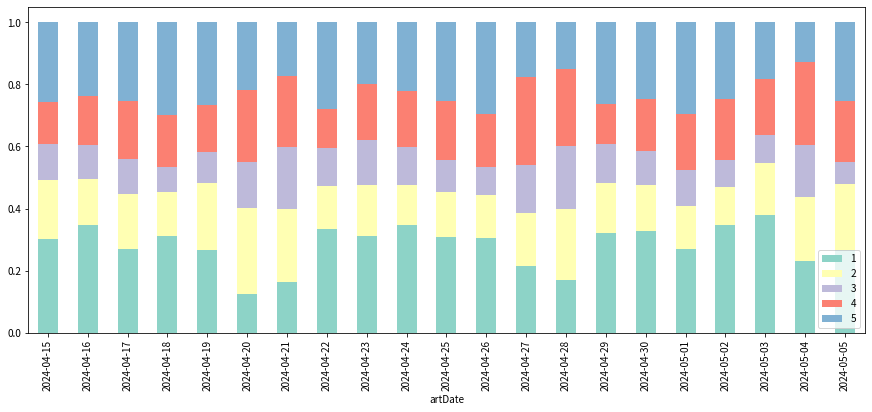

In [88]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

可以看到主題2（國際軍事衝突和地緣政治事件）在 4/20、4/21 主題2被討論的比例高於其他主題，<br>
細看文章內容圍繞在「烏克蘭武裝部隊」及「以色列與伊朗」之間的戰爭，<br>
這些文章反映了當前國際政治中一些最緊迫的安全和政治問題，特別是關於戰爭、國際合作與區域安全的議題。